In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch

from sold2.model.line_matcher import LineMatcher
from sold2.misc.visualize_util import plot_images, plot_lines, plot_line_matches, plot_color_line_matches, plot_keypoints

# Matching from scratch given pairs of images

In [2]:
ckpt_path = '../pretrained_models/sold2_wireframe.tar'
device = 'cuda'
mode = 'dynamic'  # 'dynamic' or 'static'

# Initialize the line matcher
config = {
    'model_cfg': {
        'model_name': "lcnn_simple",
        'model_architecture': "simple",
        # Backbone related config
        'backbone': "lcnn",
        'backbone_cfg': {
            'input_channel': 1, # Use RGB images or grayscale images.
            'depth': 4,
            'num_stacks': 2,
            'num_blocks': 1,
            'num_classes': 5
        },
        # Junction decoder related config
        'junction_decoder': "superpoint_decoder",
        'junc_decoder_cfg': {},
        # Heatmap decoder related config
        'heatmap_decoder': "pixel_shuffle",
        'heatmap_decoder_cfg': {},
        # Descriptor decoder related config
        'descriptor_decoder': "superpoint_descriptor",
        'descriptor_decoder_cfg': {},
        # Shared configurations
        'grid_size': 8,
        'keep_border_valid': True,
        # Threshold of junction detection
        'detection_thresh': 0.0153846, # 1/65
        'max_num_junctions': 300,
        # Threshold of heatmap detection
        'prob_thresh': 0.5,
        # Weighting related parameters
        'weighting_policy': mode,
        # [Heatmap loss]
        'w_heatmap': 0.,
        'w_heatmap_class': 1,
        'heatmap_loss_func': "cross_entropy",
        'heatmap_loss_cfg': {
            'policy': mode
        },
        # [Heatmap consistency loss]
        # [Junction loss]
        'w_junc': 0.,
        'junction_loss_func': "superpoint",
        'junction_loss_cfg': {
            'policy': mode
        },
        # [Descriptor loss]
        'w_desc': 0.,
        'descriptor_loss_func': "regular_sampling",
        'descriptor_loss_cfg': {
            'dist_threshold': 8,
            'grid_size': 4,
            'margin': 1,
            'policy': mode
        },
    },
    'line_detector_cfg': {
        'detect_thresh': 0.25,  # depending on your images, you might need to tune this parameter
        'num_samples': 64,
        'sampling_method': "local_max",
        'inlier_thresh': 0.9,
        "use_candidate_suppression": True,
        "nms_dist_tolerance": 3.,
        "use_heatmap_refinement": True,
        "heatmap_refine_cfg": {
            "mode": "local",
            "ratio": 0.2,
            "valid_thresh": 1e-3,
            "num_blocks": 20,
            "overlap_ratio": 0.5
        }
    },
    'multiscale': False,
    'line_matcher_cfg': {
        'cross_check': True,
        'num_samples': 5,
        'min_dist_pts': 8,
        'top_k_candidates': 10,
        'grid_size': 4
    }
}

line_matcher = LineMatcher(
        config["model_cfg"], ckpt_path, device, config["line_detector_cfg"],
        config["line_matcher_cfg"], config["multiscale"])



	--------Initializing model----------
	 [Debug] Adding w_junc with value 0.000000 to model
	 [Debug] Adding w_heatmap with value 0.000000 to model
	 [Debug] Adding w_desc with value 0.000000 to model
	Model architecture: simple
	Backbone: lcnn
	Junction decoder: superpoint_decoder
	Heatmap decoder: pixel_shuffle
	-------------------------------------
[Debug] detect_thresh: 0.25
[Debug] num_samples: 64
[Debug] sampling_method: local_max
[Debug] inlier_thresh: 0.9
[Debug] use_candidate_suppression: True
[Debug] nms_dist_tolerance: 3.0
[Debug] use_heatmap_refinement: True
[Debug] heatmap_refine_cfg: {'mode': 'local', 'ratio': 0.2, 'valid_thresh': 0.001, 'num_blocks': 20, 'overlap_ratio': 0.5}


/home/wzr/anaconda3/envs/demoline/lib/python3.7/site-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


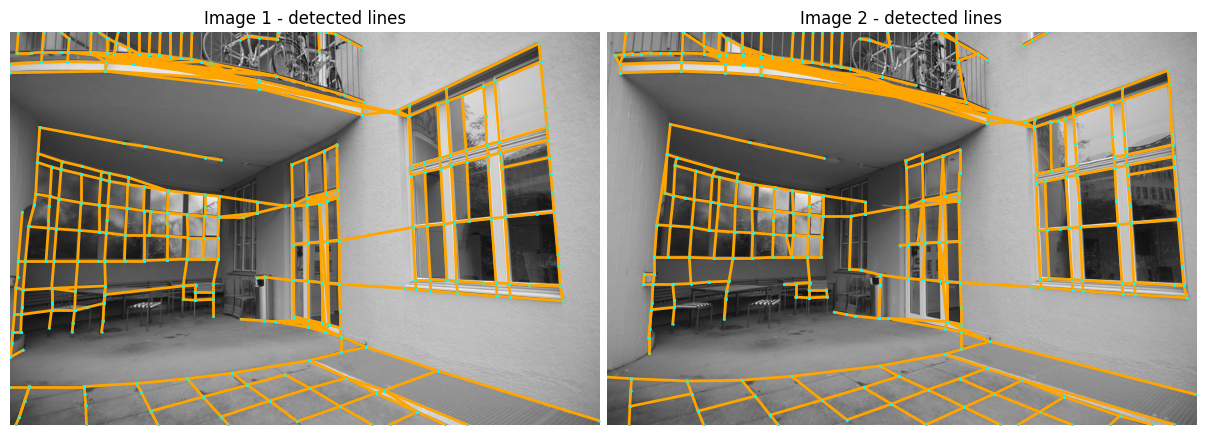

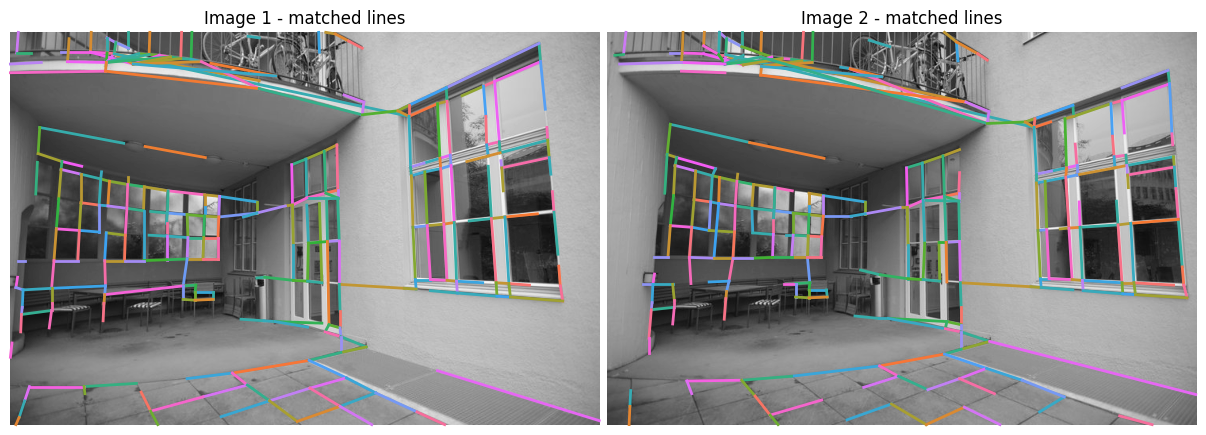

In [3]:
# Read and pre-process the images
scale_factor = 1  # we recommend resizing the images to a resolution in the range 400~800 pixels
img1 = '../assets/images/terrace0.JPG'
img1 = cv2.imread(img1, 0)
img1 = cv2.resize(img1, (img1.shape[1] // scale_factor, img1.shape[0] // scale_factor),
                  interpolation = cv2.INTER_AREA)
img1 = (img1 / 255.).astype(float)
torch_img1 = torch.tensor(img1, dtype=torch.float)[None, None]
img2 = '../assets/images/terrace1.JPG'
img2 = cv2.imread(img2, 0)
img2 = cv2.resize(img2, (img2.shape[1] // scale_factor, img2.shape[0] // scale_factor),
                  interpolation = cv2.INTER_AREA)
img2 = (img2 / 255.).astype(float)
torch_img2 = torch.tensor(img2, dtype=torch.float)[None, None]

# Match the lines
outputs = line_matcher([torch_img1, torch_img2])
line_seg1 = outputs["line_segments"][0]
line_seg2 = outputs["line_segments"][1]
matches = outputs["matches"]

valid_matches = matches != -1
match_indices = matches[valid_matches]
matched_lines1 = line_seg1[valid_matches][:, :, ::-1]
matched_lines2 = line_seg2[match_indices][:, :, ::-1]

# Plot the matches
plot_images([img1, img2], ['Image 1 - detected lines', 'Image 2 - detected lines'])
plot_lines([line_seg1[:, :, ::-1], line_seg2[:, :, ::-1]], ps=3, lw=2)
plot_images([img1, img2], ['Image 1 - matched lines', 'Image 2 - matched lines'])
plot_color_line_matches([matched_lines1, matched_lines2], lw=2)